In [10]:
library(dplyr)
library(bnlearn)
library(Rgraphviz)

In [11]:
records <- c(1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0)
data  <- data.frame(matrix(records, 10,3, byrow=TRUE))

data

X1,X2,X3
<dbl>,<dbl>,<dbl>
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1


In [12]:
scoring_function <- function(data, x_i, parents){
  # Find the possible values of the attribute i
  r_i <- data |> distinct(data[[x_i]]) |> nrow()

  if (length(parents) == 0){
    N <- nrow(data)

    num1 <- data |> 
      group_by(data[[x_i]]) |> 
      count() |> 
      mutate(a = factorial(n)) |> 
      ungroup() |> 
      pull(a) |>
      prod()

    # To do consistently with the other case
  } else {
    alpha <- data |> group_by(data[c(x_i, parents)]) |> count()

    N <- alpha |> group_by(alpha[parents]) |> 
      summarise(N = sum(n), .groups = "drop") |> 
      select(N)

    num1 <- alpha |>
      group_by(alpha[parents]) |>
      summarise(alpha = prod(factorial(n)), .groups = "drop") |>
      pull(alpha)
  }

  # Calculate the score
  den <- sapply(N, function(x, r) factorial(x + r - 1), r=r_i)
  num2 <- factorial(r_i - 1)

  return(prod(num2 / den * num1))
}

In [13]:
scoring_function(data, "X3", c())

[1] 0.0004329004

In [14]:
K2_algorithm <- function(data, max_parents){
  # If the data does not have column names, assign them
  if (is.null(names(data))) {
    names(data) <- paste0("X", 1:ncol(data))
  }

  names <- names(data)
  results <- c()

  for (i in 1:ncol(data)){
    x_i <- names[i]
    parents <- c()
    p_old <- scoring_function(data, x_i, parents)
    proceed <- TRUE
    
    while (proceed){
      # Check if the maximum number of parents has been reached
      if (length(parents) == max_parents){
        break
      }

      # Compute the predecessors
      predecessors <- setdiff(names[0:(i-1)], parents)
      if (length(predecessors) == 0){
        break
      }

      # Try adding a new parent
      scores <- sapply(predecessors, function(z) scoring_function(data, x_i, c(z, parents)))
      p_new <- max(scores)
      
      # If the score increases, add the parent
      if (p_new > p_old){
        p_old <- p_new
        parents <- c(parents, names[which.max(scores)])
      } else {
        proceed <- FALSE
      }
    } # end while
    
    results[[x_i]] <- parents
  } # end for

  return(list(names=names, parents_list=results))
}

In [15]:
res <- K2_algorithm(data, 1)
res

$names
[1] "X1" "X2" "X3"

$parents_list
$parents_list$X2
[1] "X1"

$parents_list$X3
[1] "X2"

In [16]:
get_dag <- function(names, parents_list){
  dag <- empty.graph(names)

  # Add arcs based on the parent-child relationships
  for (child in names) {
    parents <- parents_list[[child]]
    if (length(parents) > 0) {
      for (parent in parents) {
        dag <- set.arc(dag, from = parent, to = child)
      }
    }
  }
  return(dag)
}

In [17]:
dag <- get_dag(res$names, res$parents_list)

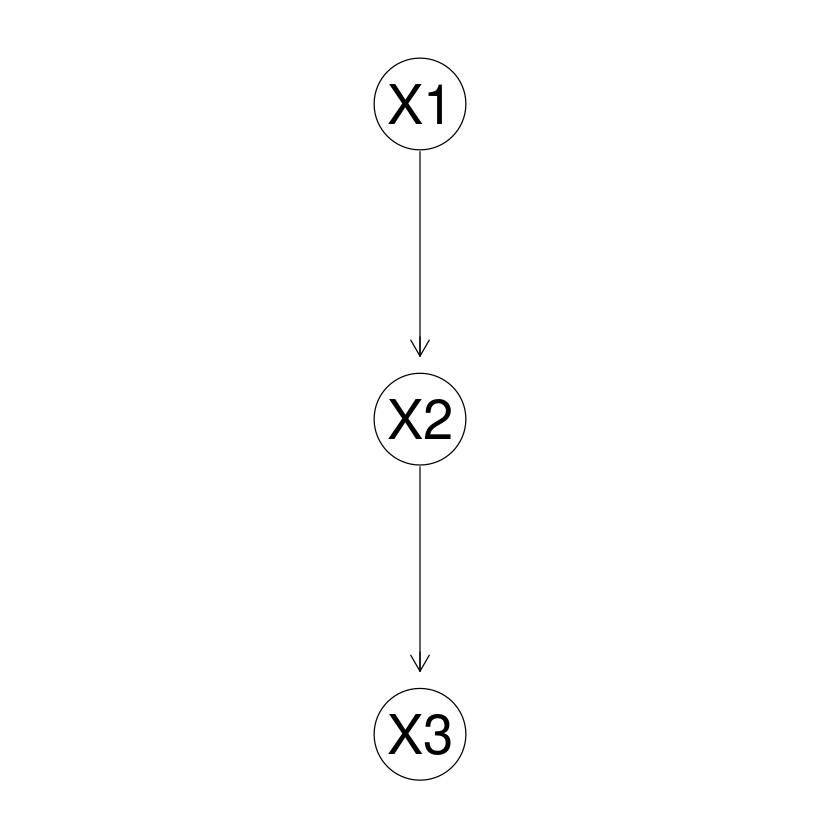

In [18]:
graphviz.plot(dag, shape="circle")